In [1]:
import pandas as pd
import numpy as np

In [2]:
high_schools = pd.read_csv('../data/full_highschool_data.csv')
high_schools.dropna(subset=['ACT'], inplace=True)

C:\Users\David\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3251: DtypeWarning: Columns (804,805,1040,1041,1159,1160,1203) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# sort columns by percentage NA
(high_schools.isna().sum()/high_schools.shape[0]).sort_values(ascending=False)

SCH_HBREPORTED_DIS_WH_F       1.0
SCH_DISCWODIS_MULTOOS_AM_M    1.0
SCH_DISCWODIS_MULTOOS_WH_F    1.0
SCH_DISCWODIS_MULTOOS_WH_M    1.0
SCH_DISCWODIS_MULTOOS_BL_F    1.0
                             ... 
TOT_DISCWODIS_EXPZT_F         0.0
TOT_DISCWODIS_EXPZT_M         0.0
SCH_DISCWODIS_EXPZT_TR_F      0.0
SCH_DISCWODIS_EXPZT_TR_M      0.0
ACT                           0.0
Length: 1397, dtype: float64

In [4]:
# drop columns with no data
high_schools = high_schools.dropna(axis=1, how='all')
high_schools.shape

(6918, 914)

In [5]:
# fill in values for missing indicators
high_schools['SCH_FIREARM_IND'].fillna(False, inplace=True)
high_schools['SCH_HOMICIDE_IND'].fillna(False, inplace=True)
high_schools['SCH_RET_G09_IND'].fillna(False, inplace=True)
high_schools['SCH_RET_G10_IND'].fillna(False, inplace=True)
high_schools['SCH_RET_G11_IND'].fillna(False, inplace=True)
high_schools['SCH_SSCLASSES_IND'].fillna(False, inplace=True)
high_schools['SCH_APSEL'].fillna(False, inplace=True)
high_schools['SCH_APMATHENR_IND'].fillna(False, inplace=True)
high_schools['SCH_APSCIENR_IND'].fillna(False, inplace=True)
high_schools['SCH_APOTHENR_IND'].fillna(False, inplace=True)

In [6]:
# fix enrolment for special cases
high_schools[~high_schools['SCH_APENR_IND']].filter(regex=r'.*_AP.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_CORPINSTANCES_IND']].filter(regex=r'.*_(DISCWO?DIS|CORPINSTANCES).*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_CREDITRECOVERY_IND']].filter(regex=r'.*_CREDITRECOVERY.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_DUAL_IND']].filter(regex=r'.*_DUAL.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_GT_IND']].filter(regex=r'.*_GTENR.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_IBENR_IND']].filter(regex=r'.*_IB.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_SSCLASSES_IND']].filter(regex=r'.*_SSCLASSES.*',axis=1).fillna(0, inplace=True)
high_schools[~high_schools['SCH_SSATHLETICS_IND']].filter(regex=r'.*_SS(SPORTS|TEAMS|PART).*',axis=1).fillna(0, inplace=True)

In [7]:
# drop columns with more than 60% na vals
high_schools = high_schools.dropna(axis=1, thresh=int(high_schools.shape[0]*(1-.6)))
high_schools.shape

(6918, 837)

In [8]:
# mark state and district name as a categorical variable
from sklearn.preprocessing import OrdinalEncoder
high_schools['LEA_STATE_NAME'] = OrdinalEncoder().fit_transform(high_schools['LEA_STATE_NAME'].to_numpy().reshape(-1,1))
high_schools['LEA_NAME'] = OrdinalEncoder().fit_transform(high_schools['LEA_NAME'].to_numpy().reshape(-1,1))

In [9]:
g = high_schools.columns.to_series().groupby(high_schools.dtypes).groups
high_schools = high_schools.loc[:,~high_schools.columns.isin({k.name: v for k, v in g.items()}['object'])]
X = high_schools.iloc[:,:-1]
X.drop(['LEAID','LEA_NAME','SCHID','COMBOKEY'], axis=1, inplace=True)
y = high_schools['ACT']

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
from sklearn.impute import KNNImputer
X_np = KNNImputer().fit_transform(X)
X = pd.DataFrame(X_np, columns=high_schools.drop(['LEAID','LEA_NAME','SCHID','COMBOKEY'], axis=1).iloc[:,:-1].columns)

In [12]:
# replace missing data with either mean or median depending on skewness
# from scipy.stats import skew
#
# for i, col in enumerate(high_schools.columns):
#     if high_schools[col].dtype == object:
#         continue
#     sk = skew(high_schools[col], nan_policy='omit')
#     if abs(sk) > 1:
#         high_schools[col].fillna(high_schools[col].median(), inplace=True)
#     else:
#         high_schools[col].fillna(high_schools[col].mean(), inplace=True)

In [13]:
X.isna().sum()

LEA_STATE_NAME                0
SCH_MATHCLASSES_ADVM          0
SCH_MATHCERT_ADVM             0
SCH_MATHENR_ADVM_HI_M         0
SCH_MATHENR_ADVM_HI_F         0
                             ..
TOT_DISCWDIS_TFRALT_IDEA_F    0
SCH_DISCWDIS_TFRALT_LEP_M     0
SCH_DISCWDIS_TFRALT_LEP_F     0
SCH_DISCWDIS_TFRALT_504_M     0
SCH_DISCWDIS_TFRALT_504_F     0
Length: 830, dtype: int64

In [14]:
X.to_csv('../data/processed_data.csv')

In [15]:
X_all_tot = X.filter(regex=r'^TOT')

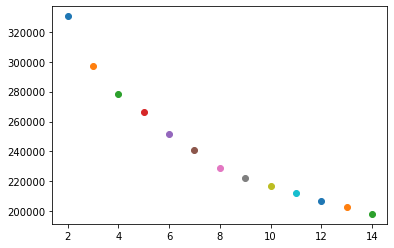

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

for k in range(2,15):
    km = KMeans(n_clusters=k).fit(X_all_tot)
    # score = silhouette_score(X, km.labels_)
    plt.scatter(k, km.inertia_)

In [17]:
km = KMeans(n_clusters=5).fit(X_all_tot)

In [18]:
X[km.labels_==0]['LEA_STATE_NAME'].value_counts(),X[km.labels_==1]['LEA_STATE_NAME'].value_counts(),X[km.labels_==2]['LEA_STATE_NAME'].value_counts(),X[km.labels_==3]['LEA_STATE_NAME'].value_counts(),X[km.labels_==4]['LEA_STATE_NAME'].value_counts()

( 0.885209    329
 -1.626549     65
 -1.417236     50
  0.257269     26
 -1.835863     24
 -0.370670     22
  1.094522     19
 -0.998610     17
  0.466583     15
  0.047956     14
  1.303836     12
  0.675896      7
 -0.579983      6
 -0.789297      4
 -1.207923      1
 Name: LEA_STATE_NAME, dtype: int64,
  0.885209    912
 -0.789297    429
 -0.370670    387
  1.303836    385
  0.047956    348
  0.675896    234
 -1.207923    233
 -1.835863    232
 -0.579983    210
  0.257269    174
 -0.998610    141
 -1.417236    134
  0.466583    124
  1.094522    101
 -0.161357     80
 -1.626549     71
  1.513149     61
 Name: LEA_STATE_NAME, dtype: int64,
  0.675896    69
  0.885209    66
 -1.417236    45
 -1.207923    23
  0.466583    12
 -0.789297     7
 -0.579983     5
  0.257269     4
  1.094522     4
 -1.626549     3
 -0.370670     1
  0.047956     1
 Name: LEA_STATE_NAME, dtype: int64,
  0.885209    295
  1.303836    261
 -0.370670    173
 -1.417236    155
  0.257269    155
 -1.626549    147
 

In [19]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_all_tot,y)
temp = lr.predict(X_all_tot)
sum((temp-y)**2)/len(temp)

4.947591026509678

In [20]:
col_groups= pd.read_excel('../data/2017-18-crdc-data/Documentation/2017-18 CRDC File Structure.xlsx', sheet_name=None)
col_groups.pop('LEA Characteristics')
col_groups.pop('High School Equivalency (GED)')
col_groups.pop('Distance Education')

,Column Finder,Field Name,Field Description
0,A,LEA_STATE,State Abbreviation
1,B,LEA_STATE_NAME,State Name
2,C,LEAID,7 Digit LEAID District Identification Code
3,D,LEA_NAME,District Name
4,E,LEA_ADDRESS,District Address
5,F,LEA_CITY,District City
6,G,LEA_ZIP,District Zip code
7,H,CJJ,"Juvenile Justice Facility (LEA): ""Yes"" indicat..."
8,I,LEA_DISTED_IND,Distance Education Enrollment Indicator (LEA):...
9,J,LEA_DISTEDENR_HI_M,Distance Education Enrollment (LEA): Hispanic...


In [21]:
from sklearn.decomposition import PCA
X_components = np.empty((len(col_groups),X.shape[1]))
means = []
for i, (name, group) in enumerate(col_groups.items()):
    # full_component = np.empty(X.shape[1])
    subset = np.intersect1d(group['Field Name'].iloc[8:], X.columns)
    if len(subset) == 0:
        continue
    pca = PCA(1).fit(X[subset])
    component = pca.components_
    means+=list(pca.mean_)
    X_components[i, list(map(lambda x: X.columns.get_loc(x), subset))] = component

In [22]:
# manually transform principle components
X_reduced = np.dot(X-X.mean(),X_components.T)[:,1:]

In [23]:
X-X.mean()

,LEA_STATE_NAME,SCH_MATHCLASSES_ADVM,SCH_MATHCERT_ADVM,SCH_MATHENR_ADVM_HI_M,SCH_MATHENR_ADVM_HI_F,SCH_MATHENR_ADVM_AM_M,SCH_MATHENR_ADVM_AM_F,SCH_MATHENR_ADVM_AS_M,SCH_MATHENR_ADVM_AS_F,SCH_MATHENR_ADVM_HP_M,...,SCH_DISCWDIS_TFRALT_IDEA_WH_M,SCH_DISCWDIS_TFRALT_IDEA_WH_F,SCH_DISCWDIS_TFRALT_IDEA_TR_M,SCH_DISCWDIS_TFRALT_IDEA_TR_F,TOT_DISCWDIS_TFRALT_IDEA_M,TOT_DISCWDIS_TFRALT_IDEA_F,SCH_DISCWDIS_TFRALT_LEP_M,SCH_DISCWDIS_TFRALT_LEP_F,SCH_DISCWDIS_TFRALT_504_M,SCH_DISCWDIS_TFRALT_504_F
0,-0.370670,0.161024,-0.569859,-0.234065,-0.201334,0.341832,0.222020,0.009494,-0.301243,-0.202043,...,-0.202925,-0.127021,-0.097642,-0.055902,-0.265758,-0.191704,-0.104003,-0.054456,-0.151187,-0.107252
1,-0.370670,0.567727,-0.569859,-0.182474,-0.151169,0.341832,1.575265,-0.284454,-0.301243,-0.202043,...,-0.202925,-0.127021,-0.097642,-0.055902,-0.265758,-0.191704,-0.104003,-0.054456,-0.151187,-0.107252
2,-0.370670,-0.449032,-0.683923,-0.234065,-0.326746,-0.240601,-0.229062,-0.137480,-0.227605,-0.202043,...,-0.202925,-0.127021,-0.097642,-0.055902,-0.265758,-0.191704,-0.104003,-0.054456,-0.151187,-0.107252
3,-0.370670,0.161024,-0.341731,0.127076,-0.050840,-0.240601,-0.229062,-0.063993,-0.006693,-0.202043,...,-0.202925,-0.127021,-0.097642,-0.055902,-0.265758,-0.191704,-0.104003,-0.054456,-0.151187,-0.107252
4,-0.370670,0.974430,-0.455795,-0.105086,0.250148,0.341832,-0.229062,-0.063993,-0.227605,1.778875,...,-0.202925,-0.127021,-0.097642,-0.055902,-0.265758,-0.191704,-0.104003,-0.054456,-0.151187,-0.107252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6913,1.513149,-0.855735,-0.683923,-0.393999,-0.407009,-0.240601,-0.229062,-0.284454,-0.301243,-0.202043,...,-0.202925,-0.127021,-0.097642,-0.055902,-0.265758,-0.191704,-0.104003,-0.054456,-0.151187,-0.107252
6914,1.513149,-0.245680,-0.113602,-0.105086,-0.050840,-0.240601,-0.229062,-0.284454,-0.227605,-0.202043,...,-0.202925,-0.127021,-0.097642,-0.055902,-0.265758,-0.191704,-0.104003,-0.054456,-0.151187,-0.107252
6915,1.513149,-0.144004,0.000462,0.023893,0.024407,-0.240601,-0.229062,-0.284454,-0.227605,-0.202043,...,-0.202925,-0.127021,-0.097642,-0.055902,-0.265758,-0.191704,-0.104003,-0.054456,-0.151187,-0.107252
6916,1.513149,-0.652383,-0.569859,-0.414636,-0.427075,-0.240601,-0.229062,-0.284454,-0.301243,-0.202043,...,-0.202925,-0.127021,-0.097642,-0.055902,-0.265758,-0.191704,-0.104003,-0.054456,-0.151187,-0.107252


In [26]:
wcss = []

for i in range(2,50):
    km = KMeans(i)
    km.fit(X_reduced)
    wcss.append(km.inertia_)

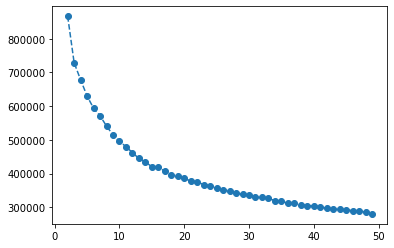

In [28]:
plt.plot(range(2,50), wcss, marker='o', linestyle='--')
plt.show()

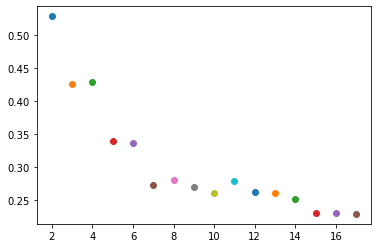

In [34]:
from sklearn.metrics import silhouette_score
for i in range(2,18):
    km = KMeans(i)
    km.fit(X_reduced)
    plt.scatter(i, silhouette_score(X_reduced, km.labels_, metric='euclidean'))